上一节基本完成了FFM，这一节对其损失函数做扩展，让它能支持更多的任务，由链式求导，我们知道：

$$
\frac{\partial L(\theta)}{\partial \theta}=\frac{\partial L(\theta)}{\partial y(x)}\frac{\partial y(x)}{\partial\theta}
$$

其中，$\frac{\partial y(x)}{\partial\theta}$对所有任务都一样，由上一节的推导我们知道：   

$$
\frac{\partial y(x)}{\partial\theta}=\left\{\begin{matrix}
1 &\theta=w_0 \\ 
x_i &\theta=w_i \\ 
v_{j,f_i,l}x_ix_j & \theta=v_{i,f_j,l}
\end{matrix}\right.
$$  

所以，我们只需要根据不同的任务求解$\frac{\partial L(\theta)}{\partial y(x)}$即可，对于最小二乘回归，我们上一节已经推导了$\frac{\partial L(\theta)}{\partial y(x)}=y(x)-t$，接下来回顾一下其他几种损失函数的梯度
### 一.回归任务扩展
回归任务的更多梯度求解在[《10_12_集成学习_xgboost_回归的更多实现：泊松回归、gamma回归、tweedie回归》](https://nbviewer.jupyter.org/github/zhulei227/ML_Notes/blob/master/notebooks/10_12_%E9%9B%86%E6%88%90%E5%AD%A6%E4%B9%A0_xgboost_%E5%9B%9E%E5%BD%92%E7%9A%84%E6%9B%B4%E5%A4%9A%E5%AE%9E%E7%8E%B0%EF%BC%9A%E6%B3%8A%E6%9D%BE%E5%9B%9E%E5%BD%92%E3%80%81gamma%E5%9B%9E%E5%BD%92%E3%80%81tweedie%E5%9B%9E%E5%BD%92.ipynb)中已经做推导，下面再列一下  

#### possion回归
$$
\frac{\partial L(\theta)}{\partial y(x)}=e^{y(x)}-t
$$
#### gamma回归
$$
\frac{\partial L(\theta)}{\partial y(x)}=1-te^{-y(x)}
$$
#### tweedie回归
$$
\frac{\partial L(\theta)}{\partial y(x)}=\left\{\begin{matrix}
e^{y(x)}-t & p=1\\ 
1-te^{-y(x)} &p=2\\ 
(2-p)e^{y(x)(2-p)}-(1-p)te^{y(x)(1-p)} & p\neq 1,p\neq 2 
\end{matrix}\right.
$$

### 二.分类任务扩展
对于二分类任务，我们参考[《02_线性模型_逻辑回归》](https://nbviewer.jupyter.org/github/zhulei227/ML_Notes/blob/master/notebooks/02_%E7%BA%BF%E6%80%A7%E6%A8%A1%E5%9E%8B_%E9%80%BB%E8%BE%91%E5%9B%9E%E5%BD%92.ipynb)中的推导，即相对线性模型套一个sigmoid函数，然后损失函数取交叉熵

#### 二分类

$$
\frac{\partial L(\theta)}{\partial y(x)}=\sigma(y(x))-t
$$  

这里，$\sigma(\cdot)$即是sigmoid函数  

#### 多分类

多分类的任务实现，可以参考[《10_06_集成学习_boosting_gbm_classifier》](https://nbviewer.jupyter.org/github/zhulei227/ML_Notes/blob/master/notebooks/10_06_%E9%9B%86%E6%88%90%E5%AD%A6%E4%B9%A0_boosting_gbm_classifier.ipynb)，即独立训练多个FFM模型方程，然后对它们做softmax然后取交叉熵，但这里就偷个懒不去实现了，可以利用[《03_二分类转多分类的一般实现》](https://nbviewer.jupyter.org/github/zhulei227/ML_Notes/blob/master/notebooks/03_%E4%BA%8C%E5%88%86%E7%B1%BB%E8%BD%AC%E5%A4%9A%E5%88%86%E7%B1%BB%E7%9A%84%E4%B8%80%E8%88%AC%E5%AE%9E%E7%8E%B0.ipynb)中的方法，通过ovo或者ovr的方式来将二分类问题转化为多分类问题

### 三.代码实现

In [1]:
"""
FFM因子分解机的实现
"""
import os
os.chdir('../')
import numpy as np
from ml_models import utils


class FFM(object):
    def __init__(self, epochs=1, lr=1e-3, adjust_lr=True, batch_size=1, hidden_dim=4, lamb=1e-3, alpha=1e-3,
                 normal=True, solver='adam', rho_1=0.9, rho_2=0.999, early_stopping_rounds=100,
                 objective="squarederror", tweedie_p=1.5):
        """

        :param epochs: 迭代轮数
        :param lr: 学习率
        :param adjust_lr:是否根据特征数量再次调整学习率 max(lr,1/n_feature)
        :param batch_size:
        :param hidden_dim:隐变量维度
        :param lamb:l2正则项系数
        :param alpha:l1正则项系数
        :param normal:是否归一化，默认用min-max归一化
        :param solver:优化方式，包括sgd,adam,默认adam
        :param rho_1:adam的rho_1的权重衰减,solver=adam时生效
        :param rho_2:adam的rho_2的权重衰减,solver=adam时生效
        :param early_stopping_rounds:对early_stopping进行支持，默认100，使用rmse作为回归任务评估指标，使用错误率（1-accuray）作为分类任务的评估指标
        :param objective:损失函数，回归任务支持squarederror,poisson,gamma,tweedie，分类任务支持logistic
        :param tweedie_p:teweedie的超参数，objective=tweedie时生效
        """
        self.epochs = epochs
        self.lr = lr
        self.adjust_lr = adjust_lr
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.lamb = lamb
        self.alpha = alpha
        self.solver = solver
        self.rho_1 = rho_1
        self.rho_2 = rho_2
        self.early_stopping_rounds = early_stopping_rounds
        self.objective = objective
        self.tweedie_p = tweedie_p
        # 初始化参数
        self.w = None  # w_0,w_i
        self.V = None  # v_{i,f}
        # 归一化
        self.normal = normal
        if normal:
            self.xmin = None
            self.xmax = None
        # 功能性参数
        self.replace_ind = None  # 置换index
        self.positive_ind = None  # 参与特征组合的开始id
        self.fields = []  # replace_ind后的fields
        self.field_num = None

    def _y(self, X):
        """
        实现y(x)的功能
        :param X:
        :return:
        """
        # 去掉第一列bias以及非组合特征
        X_ = X[:, self.positive_ind + 1:]
        n_sample, n_feature = X_.shape
        pol = np.zeros(n_sample)
        for i in range(0, n_feature - 1):
            for j in range(i + 1, n_feature):
                pol += X_[:, i] * X_[:, j] * np.dot(self.V[i, self.fields[self.positive_ind + j]],
                                                    self.V[j, self.fields[self.positive_ind + i]])
        linear_rst = X @ self.w.reshape(-1) + pol
        return linear_rst

    def fit(self, X, y, eval_set=None, show_log=False, fields=None):
        """
        :param X:
        :param y:
        :param eval_set:
        :param show_log:
        :param fields: 为None时，退化为FM
        :return:
        """
        X_o = X.copy()

        # 归一化
        if self.normal:
            self.xmin = X.min(axis=0)
            self.xmax = X.max(axis=0)
            X = (X - self.xmin) / self.xmax

        n_sample, n_feature = X.shape
        # 处理fields
        if fields is None:
            self.replace_ind = list(range(0, n_feature))
            self.positive_ind = 0
            self.fields = [0] * n_feature
            self.field_num = 1
        else:
            self.replace_ind = np.argsort(fields).tolist()
            self.positive_ind = np.sum([1 if item < 0 else 0 for item in fields])
            self.fields = sorted(fields)
            self.field_num = len(set(self.fields[self.positive_ind:]))

        # reshape X
        X = X[:, self.replace_ind]

        x_y = np.c_[np.ones(n_sample), X, y]
        # 记录loss
        train_losses = []
        eval_losses = []
        # 调整一下学习率
        if self.adjust_lr:
            self.lr = max(self.lr, 1 / n_feature)
        # 初始化参数
        self.w = np.random.random((n_feature + 1, 1)) * 1e-3
        self.V = np.random.random((n_feature - self.positive_ind, self.field_num, self.hidden_dim)) * 1e-3
        if self.solver == 'adam':
            # 缓存梯度一阶，二阶估计
            w_1 = np.zeros_like(self.w)
            V_1 = np.zeros_like(self.V)
            w_2 = np.zeros_like(self.w)
            V_2 = np.zeros_like(self.V)
        # 更新参数
        count = 0
        for epoch in range(self.epochs):
            # 验证集记录
            best_eval_value = np.power(2., 1023)
            eval_count = 0
            np.random.shuffle(x_y)
            for index in range(x_y.shape[0] // self.batch_size):
                count += 1
                batch_x_y = x_y[self.batch_size * index:self.batch_size * (index + 1)]
                batch_x = batch_x_y[:, :-1]
                batch_y = batch_x_y[:, -1:]
                # 计算链式求导第一层梯度
                if self.objective == "squarederror":
                    y_x_t = self._y(batch_x).reshape((-1, 1)) - batch_y
                elif self.objective == "poisson":
                    y_x_t = np.exp(self._y(batch_x).reshape((-1, 1))) - batch_y
                elif self.objective == "gamma":
                    y_x_t = 1.0 - batch_y * np.exp(-1.0 * self._y(batch_x).reshape((-1, 1)))
                elif self.objective == 'tweedie':
                    if self.tweedie_p == 1:
                        y_x_t = np.exp(self._y(batch_x).reshape((-1, 1))) - batch_y
                    elif self.tweedie_p == 2:
                        y_x_t = 1.0 - batch_y * np.exp(-1.0 * self._y(batch_x).reshape((-1, 1)))
                    else:
                        y_x_t = np.exp(self._y(batch_x).reshape((-1, 1)) * (2.0 - self.tweedie_p)) \
                                - batch_y * np.exp(self._y(batch_x).reshape((-1, 1)) * (1.0 - self.tweedie_p))
                else:
                    # 二分类
                    y_x_t = utils.sigmoid(self._y(batch_x).reshape((-1, 1))) - batch_y

                # 更新w
                if self.solver == 'sgd':
                    self.w = self.w - (self.lr * (np.sum(y_x_t * batch_x, axis=0) / self.batch_size).reshape(
                        (-1, 1)) + self.lamb * self.w + self.alpha * np.where(self.w > 0, 1, 0))
                elif self.solver == 'adam':
                    w_reg = self.lamb * self.w + self.alpha * np.where(self.w > 0, 1, 0)
                    w_grad = (np.sum(y_x_t * batch_x, axis=0) / self.batch_size).reshape(
                        (-1, 1)) + w_reg
                    w_1 = self.rho_1 * w_1 + (1 - self.rho_1) * w_grad
                    w_2 = self.rho_2 * w_2 + (1 - self.rho_2) * w_grad * w_grad
                    w_1_ = w_1 / (1 - np.power(self.rho_1, count))
                    w_2_ = w_2 / (1 - np.power(self.rho_2, count))
                    self.w = self.w - (self.lr * w_1_) / (np.sqrt(w_2_) + 1e-8)

                # 更新 V
                batch_x_ = batch_x[:, 1 + self.positive_ind:]
                # 逐元素更新
                for i in range(0, batch_x_.shape[1] - 1):
                    for j in range(i + 1, batch_x_.shape[1]):
                        for k in range(0, self.hidden_dim):
                            v_reg_l = self.lamb * self.V[i, self.fields[self.positive_ind + j], k] + \
                                      self.alpha * (self.V[i, self.fields[self.positive_ind + j], k] > 0)

                            v_grad_l = np.sum(y_x_t.reshape(-1) * batch_x_[:, i] * batch_x_[:, j] *
                                              self.V[
                                                  j, self.fields[self.positive_ind + i], k]) / self.batch_size + v_reg_l

                            v_reg_r = self.lamb * self.V[j, self.fields[self.positive_ind + i], k] + \
                                      self.alpha * (self.V[j, self.fields[self.positive_ind + i], k] > 0)

                            v_grad_r = np.sum(y_x_t.reshape(-1) * batch_x_[:, i] * batch_x_[:, j] *
                                              self.V[
                                                  i, self.fields[self.positive_ind + j], k]) / self.batch_size + v_reg_r

                            if self.solver == "sgd":
                                self.V[i, self.fields[self.positive_ind + j], k] -= self.lr * v_grad_l
                                self.V[j, self.fields[self.positive_ind + i], k] -= self.lr * v_grad_r
                            elif self.solver == "adam":
                                V_1[i, self.fields[self.positive_ind + j], k] = self.rho_1 * V_1[
                                    i, self.fields[self.positive_ind + j], k] + (1 - self.rho_1) * v_grad_l
                                V_2[i, self.fields[self.positive_ind + j], k] = self.rho_2 * V_2[
                                    i, self.fields[self.positive_ind + j], k] + (1 - self.rho_2) * v_grad_l * v_grad_l
                                v_1_l = V_1[i, self.fields[self.positive_ind + j], k] / (
                                    1 - np.power(self.rho_1, count))
                                v_2_l = V_2[i, self.fields[self.positive_ind + j], k] / (
                                    1 - np.power(self.rho_2, count))

                                V_1[j, self.fields[self.positive_ind + i], k] = self.rho_1 * V_1[
                                    j, self.fields[self.positive_ind + i], k] + (1 - self.rho_1) * v_grad_r
                                V_2[j, self.fields[self.positive_ind + i], k] = self.rho_2 * V_2[
                                    j, self.fields[self.positive_ind + i], k] + (1 - self.rho_2) * v_grad_r * v_grad_r
                                v_1_r = V_1[j, self.fields[self.positive_ind + i], k] / (
                                    1 - np.power(self.rho_1, count))
                                v_2_r = V_2[j, self.fields[self.positive_ind + i], k] / (
                                    1 - np.power(self.rho_2, count))

                                self.V[i, self.fields[self.positive_ind + j], k] -= (self.lr * v_1_l) / (
                                    np.sqrt(v_2_l) + 1e-8)

                                self.V[j, self.fields[self.positive_ind + i], k] -= (self.lr * v_1_r) / (
                                    np.sqrt(v_2_r) + 1e-8)

                # 计算eval loss
                eval_loss = None
                if eval_set is not None:
                    eval_x, eval_y = eval_set
                    if self.objective == 'logistic':
                        eval_loss = np.mean(eval_y != self.predict(eval_x))
                    else:
                        eval_loss = np.std(eval_y - self.predict(eval_x))
                    eval_losses.append(eval_loss)
                # 是否显示
                if show_log:
                    if self.objective == 'logistic':
                        train_loss = np.mean(y != self.predict(X_o))
                    else:
                        train_loss = np.std(y - self.predict(X_o))
                    print("epoch:", epoch + 1, "/", self.epochs, ",samples:", (index + 1) * self.batch_size, "/",
                          n_sample,
                          ",train loss:",
                          train_loss, ",eval loss:", eval_loss)
                    train_losses.append(train_loss)
                # 是否早停
                if eval_loss is not None and self.early_stopping_rounds is not None:
                    if eval_loss < best_eval_value:
                        eval_count = 0
                        best_eval_value = eval_loss
                    else:
                        eval_count += 1
                    if eval_count >= self.early_stopping_rounds:
                        print("---------------early_stopping-----------------------------")
                        break

        return train_losses, eval_losses

    def predict_proba(self, X):
        """
        logistic regression用
        :param X:
        :return:
        """
        # 归一化
        if self.normal:
            X = (X - self.xmin) / self.xmax
        # reshape
        X = X[:, self.replace_ind]
        # 去掉第一列bias以及非组合特征
        X_ = X[:, self.positive_ind:]
        n_sample, n_feature = X_.shape
        pol = np.zeros(n_sample)
        for i in range(0, n_feature - 1):
            for j in range(i + 1, n_feature):
                pol += X_[:, i] * X_[:, j] * np.dot(self.V[i, self.fields[self.positive_ind + j]],
                                                    self.V[j, self.fields[self.positive_ind + i]])
        pos_proba = utils.sigmoid(np.c_[np.ones(n_sample), X] @ self.w.reshape(-1) + pol)
        return np.c_[1.0-pos_proba,pos_proba]

    def predict(self, X):
        """
        :param X:
        :return:
        """
        # 归一化
        if self.normal:
            X = (X - self.xmin) / self.xmax
        # reshape
        X = X[:, self.replace_ind]
        # 去掉第一列bias以及非组合特征
        X_ = X[:, self.positive_ind:]
        n_sample, n_feature = X_.shape
        pol = np.zeros(n_sample)
        for i in range(0, n_feature - 1):
            for j in range(i + 1, n_feature):
                pol += X_[:, i] * X_[:, j] * np.dot(self.V[i, self.fields[self.positive_ind + j]],
                                                    self.V[j, self.fields[self.positive_ind + i]])

        linear_rst = np.c_[np.ones(n_sample), X] @ self.w.reshape(-1) + pol
        if self.objective == "squarederror":
            return linear_rst
        elif self.objective in ["poisson", "gamma", "tweedie"]:
            return np.exp(linear_rst)
        else:
            return utils.sigmoid(linear_rst) > 0.5

### 四.测试

#### 回归测试

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#造伪数据
data1 = np.linspace(1, 10, num=100)
data2 = np.linspace(1, 10, num=100) + np.random.random(size=100)
data3 = np.linspace(10, 1, num=100)
target = data1 * 2 + data3 * 0.1 + data2 * 1 + 10 * data1 * data2 + np.random.random(size=100)
data = np.c_[data1, data2, data3]

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.4, random_state=0)

#### squarederror

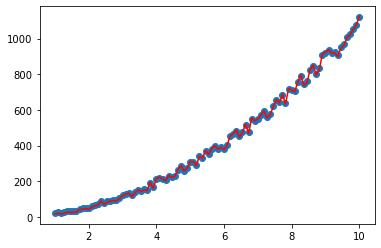

In [5]:
model = FFM(epochs=10)
train_losses,eval_losses = model.fit(X_train, y_train, eval_set=(X_test,y_test))
plt.scatter(data[:, 0], target)
plt.plot(data[:, 0], model.predict(data), color='r')

#### tweedie

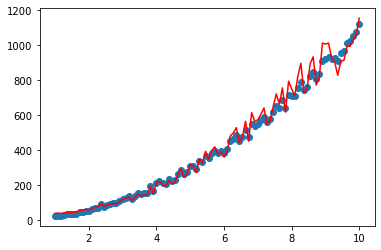

In [6]:
model = FFM(epochs=10,objective='tweedie')
train_losses,eval_losses = model.fit(X_train, y_train, eval_set=(X_test,y_test))
plt.scatter(data[:, 0], target)
plt.plot(data[:, 0], model.predict(data), color='r')

#### poisson

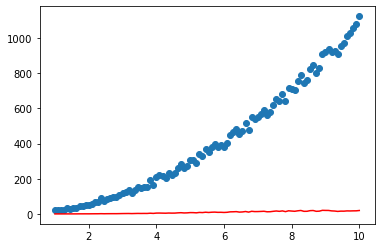

In [7]:
model = FFM(epochs=10,objective='poisson')
train_losses,eval_losses = model.fit(X_train, y_train, eval_set=(X_test,y_test))
plt.scatter(data[:, 0], target)
plt.plot(data[:, 0], model.predict(data), color='r')

#### gamma

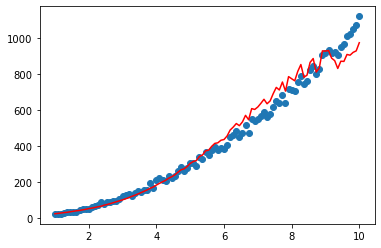

In [8]:
model = FFM(epochs=10,objective='gamma')
train_losses,eval_losses = model.fit(X_train, y_train, eval_set=(X_test,y_test))
plt.scatter(data[:, 0], target)
plt.plot(data[:, 0], model.predict(data), color='r')

#### 分类

In [9]:
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=200, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1)

#### 二分类

In [10]:
ffm=FFM(epochs=10, solver='adam',objective='logistic')
ffm.fit(data,target)
utils.plot_decision_function(data,target,ffm)

#### 多分类

In [ ]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.85, random_state=0)
X = X[:, ::-1]

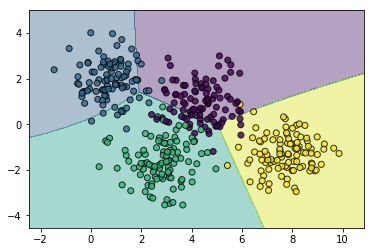

In [ ]:
from ml_models.wrapper_models import *
ffm=FFM(epochs=10, solver='adam',objective='logistic')
ovr = MultiClassWrapper(ffm, mode='ovr')
ovr.fit(X, y)
utils.plot_decision_function(X,y,ovr)